In [1]:
## Importing Requisite Libraries

#Model Libraries:
import numpy as np
import pandas as pd
import os
from glob import glob
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from PIL import Image
np.random.seed(123)
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#Visualization Libraries:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
    

Using TensorFlow backend.


In [2]:
## STEP 1> Data Preprocessing

#Splitting image data at location:
base_skin_dir = os.path.join('E:\Textual and Pictorial Archive\Machine Learning\DataSets', 'skin-cancer-mnist-ham10000') 
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

#Setting up Dictionary:
lesion_type_dict = {
                       'nv': 'Melanocytic nevi',
                       'mel': 'Melanoma',
                       'bkl': 'Benign keratosis-like lesions ',
                       'bcc': 'Basal cell carcinoma',
                       'akiec': 'Actinic keratoses',
                       'vasc': 'Vascular lesions',
                       'df': 'Dermatofibroma'
                    }



In [3]:
#Reading Cancer_Dataset CSV:
cancer_dataset = pd.read_csv('E:\Textual and Pictorial Archive\Machine Learning\DataSets\skin-cancer-mnist-ham10000\HAM10000_metadata.csv')

#Adding Columns to Cancer_Dataset:
cancer_dataset['path'] = cancer_dataset['image_id'].map(imageid_path_dict.get)
cancer_dataset['cell_type'] = cancer_dataset['dx'].map(lesion_type_dict.get)

#Encoding 'cell_type' Column in Dataset:
cancer_dataset['cell_type_idx'] = pd.Categorical(cancer_dataset['cell_type']).codes



In [4]:
#Displaying first 5 rows from Cancer_Dataset:
cancer_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,E:\Textual and Pictorial Archive\Machine Learn...,Melanocytic nevi,4
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,E:\Textual and Pictorial Archive\Machine Learn...,Melanocytic nevi,4
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,E:\Textual and Pictorial Archive\Machine Learn...,Melanocytic nevi,4
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,E:\Textual and Pictorial Archive\Machine Learn...,Melanocytic nevi,4
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,E:\Textual and Pictorial Archive\Machine Learn...,Melanoma,5


In [5]:
#Filling missing entries in the dataset with average values:
cancer_dataset['age'].fillna((cancer_dataset['age'].mean()), inplace=True)

In [6]:
#Obtaining images from directory and resizing to 64x64:
cancer_dataset['image'] = cancer_dataset['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

In [7]:
#Displaying first 5 rows from Cancer_Dataset after update:
cancer_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,E:\Textual and Pictorial Archive\Machine Learn...,Melanocytic nevi,4,"[[[229, 133, 135], [231, 122, 128], [228, 124,..."
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,E:\Textual and Pictorial Archive\Machine Learn...,Melanocytic nevi,4,"[[[217, 121, 135], [224, 131, 150], [216, 123,..."
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,E:\Textual and Pictorial Archive\Machine Learn...,Melanocytic nevi,4,"[[[245, 172, 183], [247, 167, 176], [247, 174,..."
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,E:\Textual and Pictorial Archive\Machine Learn...,Melanocytic nevi,4,"[[[211, 120, 137], [208, 119, 137], [206, 113,..."
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,E:\Textual and Pictorial Archive\Machine Learn...,Melanoma,5,"[[[72, 33, 38], [71, 30, 38], [67, 28, 29], [8..."


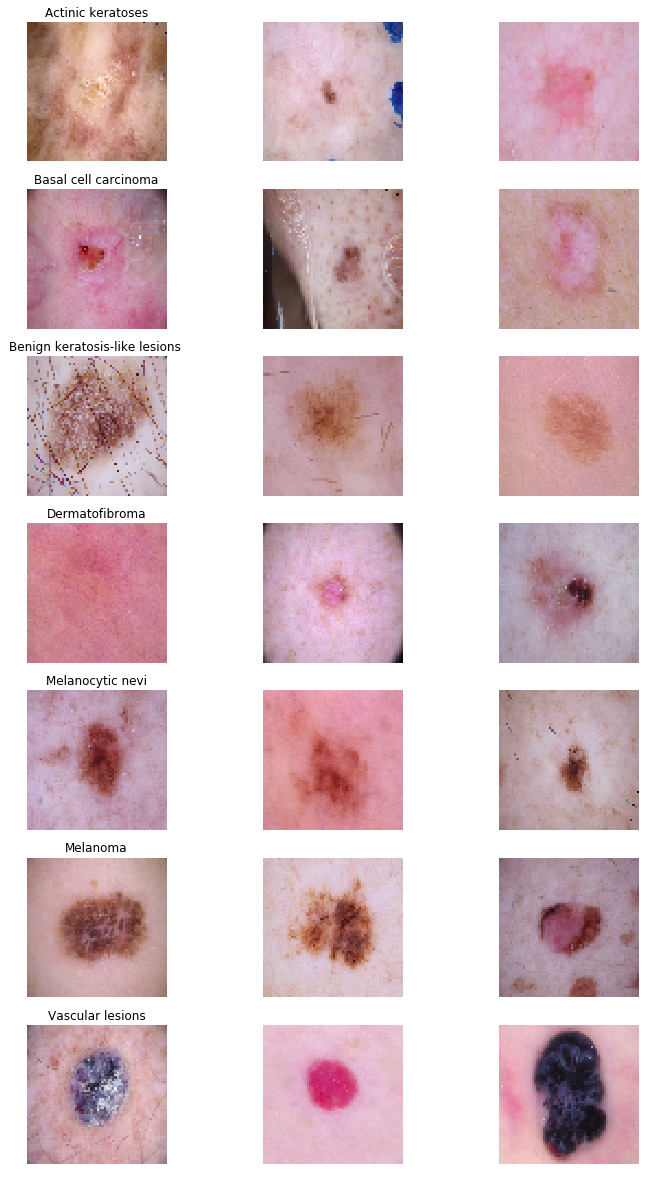

In [8]:
## STEP 2> Displaying samples

n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         cancer_dataset.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [9]:
#Counting Image size, No. of Channels, and No. of images:
cancer_dataset['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    10015
Name: image, dtype: int64

In [10]:
## STEP 4> Selecting the features and targets

#Setting Features and Target:
features = cancer_dataset.drop(columns=['cell_type_idx'], axis = 1)
target = cancer_dataset['cell_type_idx']

In [11]:
## STEP 5> Train Test Splitting

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size = 0.20, random_state=13269) 

In [12]:
## STEP 6> Normalising the training set

#Setting up Training-Testing Arrays:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

#Calculating Mean and Std. Deviation (Test and Train):
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

#Normalization Formula (Train and Test):
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [13]:
## STEP 7> Performing one-hot encoding on the labels

y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [14]:
## STEP 8> Validation and Training set splitting

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2) 

In [15]:
## STEP 9> Reshaping image into 3 dimensions

x_train = x_train.reshape(x_train.shape[0], *(64, 64, 3))
x_test = x_test.reshape(x_test.shape[0], *(64, 64, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(64, 64, 3))

In [16]:
## STEP 10> Building the CNN model 

#Initializing input-shape and no. of classes:
input_shape = (64, 64, 3)
num_classes = 7

#Setting up CNN Classifier Layer-set 1 (4 Layers):
classifier = Sequential()
classifier.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
classifier.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size = (2, 2)))
classifier.add(Dropout(0.15))

#Setting up CNN Classifier Layer-set 2 (4 Layers):
classifier.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
classifier.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
classifier.add(MaxPool2D(pool_size=(2, 2)))
classifier.add(Dropout(0.20))

#Setting up CNN Classifier Layer-set 3 (4 Layers):
classifier.add(Flatten())
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(num_classes, activation='softmax'))

#Displaying Summary of all 12 Neural Layers created:
classifier.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [17]:
## STEP 11> Compiling the CNN model

classifier.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

## _STEP 12> Image Augmentation_

In [32]:
## STEP 12> Image Augmentation

#Initializing Data Generating Object to perform Image Augmentation through ImageDataGenerator Function:
datagen = ImageDataGenerator(
                                featurewise_center = False, 
                                samplewise_center = False,  
                                featurewise_std_normalization = False, 
                                samplewise_std_normalization = False, 
                                zca_whitening = False, 
                                rotation_range = 90, 
                                zoom_range = 0.1,  
                                width_shift_range = 0.1, 
                                height_shift_range = 0.1,
                                horizontal_flip = True,  
                                vertical_flip = True
                            )

#Fitting Training data to CNN model:
datagen.fit(x_train)

In [ ]:
## STEP 13> Fitting the CNN model

#Initializing no. of epochs and batch-size:
epochs = 30 
batch_size = 10

#Fitting data to model and saving it to variable 'history':
history = classifier.fit_generator(
                                       datagen.flow(x_train,y_train, batch_size=batch_size),
                                       epochs = epochs, validation_data = (x_validate,y_validate),
                                       steps_per_epoch = 400
                                  )

Epoch 1/30
252/400 [=================>............] - ETA: 17s - loss: 0.9814 - acc: 0.6651

In [34]:
#Step 14:- Calculating validation set and test set accuracies
loss, accuracy = classifier.evaluate(x_test, y_test)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
classifier.save("classifier.h5")

802/802 [==============================] - 3s 4ms/step
Validation: accuracy = 0.748130  ;  loss_v = 0.729199
Test: accuracy = 0.735896  ;  loss = 0.712291
